# I Projekt ZMUM - Klasyfikator binarny
### Wojciech Celej

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.decomposition import *
from sklearn.feature_selection import *

import xgboost
import lightgbm
import catboost
from sklearn.ensemble import RandomForestClassifier
import shap

import category_encoders as ce
from collections import defaultdict

## Wczytanie danych

In [2]:
train_df = pd.read_csv("train.txt", sep = " ").sort_index()
test_df = pd.read_csv("testx.txt", sep = " ").sort_index()

In [3]:
X = train_df.loc[:, train_df.columns != "class"]
y = train_df["class"]

In [4]:
# Trenowanie modeli
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
# Zapisanie prawdziwych eytkiet zbioru testowego
y_test.to_frame().to_csv("y_true.csv", index=False)

In [ ]:
# Finalna predykcja
X_train = X
y_train = y
X_test = test_df.loc[:, train_df.columns != "class"]

## Usunięcie pustych kolumn

In [5]:
def drop_empty_columns(train_df, test_df):
    columns_to_drop =[]
    for column in train_df.columns:
        if train_df[column].isna().all():
            columns_to_drop.append(column)
    if columns_to_drop:
        new_train_df = train_df.drop(columns=columns_to_drop)
        new_test_df = test_df.drop(columns=columns_to_drop)
        
    return new_train_df, new_test_df

In [6]:
X_train, X_test = drop_empty_columns(X_train, X_test)

## Usunięcie kolumn kategorycznych powtarzających się

In [7]:
def count_categories_in_columns(train_df):
    cat_df = train_df.select_dtypes(exclude=["number"])
    num_unique_values_map = defaultdict(list)
    for i in range(0, cat_df.shape[1]):
        column = cat_df.iloc[:, i]
        num_unique = column.nunique(dropna=False)
        num_unique_values_map[num_unique].append(column.name)
    return num_unique_values_map

In [8]:
num_unique_values_map = count_categories_in_columns(X_train)

In [9]:
def drop_repeated_cat_columns(train_df, test_df, num_unique_values_map):
    columns_to_drop = set()
    for key, value in num_unique_values_map.items():
        len_col_list = len(value)
        if len_col_list > 1:
            for i in range(len_col_list):
                col_name_i = value[i]
                for j in range(i+1, len_col_list):
                    col_name_j = value[j]
                    lab_encoder = ce.OrdinalEncoder()
                    transformed = lab_encoder.fit_transform(train_df[[col_name_i, col_name_j]])
                    if accuracy_score(transformed.iloc[:, 0], transformed.iloc[:, 1]) > 0.99:
                        columns_to_drop.add(col_name_i)
                        break
    return train_df.drop(columns=columns_to_drop), test_df.drop(columns=columns_to_drop)

In [10]:
X_train, X_test = drop_repeated_cat_columns(X_train, X_test, num_unique_values_map)

## Usunięcie kolumn o liczbie kategorii  większej niż *n*

In [11]:
def drop_columns_above_n_categories(train_df, test_df, n):
    columns_to_drop = set()
    cat_columns = train_df.select_dtypes(exclude=["number"]).columns
    for column in cat_columns:
        if train_df[column].nunique(dropna=False) > n:
            columns_to_drop.add(column)
    return train_df.drop(columns=columns_to_drop), test_df.drop(columns=columns_to_drop)

In [12]:
X_train, X_test = drop_columns_above_n_categories(X_train, X_test, 100)

## Wypełnienie pustych zmiennych numerycznych i dodanie kolumn informujących o NaN

In [13]:
def fill_na_in_numerical_add_column(train_df, test_df):
    new_train_df = train_df.copy()
    new_test_df = test_df.copy()
    numerical_columns = new_train_df.select_dtypes(include=["number"]).columns
    for column in numerical_columns:
        if new_train_df[column].isna().any():
            new_train_df[column+"_isfilled"] = new_train_df[column].isna().map({True:"yes", False:"no"})
            new_test_df[column+"_isfilled"] = new_test_df[column].isna().map({True:"yes", False:"no"})
        new_train_df[column] = new_train_df[column].fillna(new_train_df[column].median())
        new_test_df[column] = new_test_df[column].fillna(new_train_df[column].median())
    return new_train_df, new_test_df

In [14]:
X_train, X_test = fill_na_in_numerical_add_column(X_train, X_test)
X_train.shape

(32000, 372)

## Zakodowanie zmiennych kategorycznych

In [15]:
label_encoder = ce.WOEEncoder(drop_invariant=False, randomized=True)
#label_encoder = ce.TargetEncoder(smoothing=20, min_samples_leaf=2)

In [16]:
label_encoder.fit(X_train, y_train)

WOEEncoder(cols=['Var191', 'Var193', 'Var194', 'Var195', 'Var196', 'Var201', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var213', 'Var215', 'Var218', 'Var219', 'Var221', 'Var223', 'Var224', 'Var225', 'Var226', 'Var227', 'Var228', 'Var229', 'Var1_isfilled', 'Var2_i...led', 'Var186_isfilled', 'Var187_isfilled', 'Var188_isfilled', 'Var189_isfilled', 'Var190_isfilled'],
      drop_invariant=False, handle_missing='value', handle_unknown='value',
      random_state=None, randomized=True, regularization=1.0,
      return_df=True, sigma=0.05, verbose=0)

In [17]:
X_train = label_encoder.transform(X_train)
X_test = label_encoder.transform(X_test)
X_train.shape

(32000, 372)

## Robust scaler

In [18]:
def robust_scaler(train_df, test_df):
    new_train_df = train_df.copy()
    new_test_df = test_df.copy()
    numerical_columns = new_train_df.select_dtypes(include=["number"]).columns
    robust_scaler = RobustScaler()
    robust_scaler.fit(new_train_df[numerical_columns])
    new_train_df[numerical_columns] = robust_scaler.transform(new_train_df[numerical_columns])
    new_test_df[numerical_columns] = robust_scaler.transform(new_test_df[numerical_columns])
    return new_train_df, new_test_df

In [19]:
X_train, X_test = robust_scaler(X_train, X_test)

## Zebranie funkcji razem

In [20]:
def data_transformation(X_train, X_test, y_train):
    X_train, X_test = drop_columns_above_n_categories(X_train, X_test, 100)
    X_train, X_test = fill_na_in_numerical_add_column(X_train, X_test)
    label_encoder = ce.WOEEncoder(drop_invariant=False, randomized=True)
    label_encoder.fit(X_train, y_train)
    X_train = label_encoder.transform(X_train)
    X_test = label_encoder.transform(X_test)
    X_train, X_test = robust_scaler(X_train, X_test)
    return X_train, X_test

## Funkcje liczące jakość klasyfikacji i frakcję "1"

In [21]:
def prec_score_10(y_true, y_pred_proba):
    Y = pd.DataFrame({"y_pred": y_pred_proba, "y_true": y_true})
    n = int(np.floor(y_pred_proba.shape[0]*0.1)+1)
    Y = Y.sort_values("y_pred", ascending=False).head(n)
    return Y["y_true"].mean(), roc_auc_score(y_true, y_pred_proba)

def calculate_scores(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return acc, recall, precision

def weight_ratio(y_train):
    num = y_train.value_counts()
    return num[0]/num[1]

## Modele

### xgboost model

In [22]:
xgb_params = {
    "learning_rate": 0.01,
    "n_estimators": 5000,
    "subsample": 0.9,
    "max_depth": 3,
    "colsample_bytree": 0.4,
    "gamma": 0.5,
    "reg_alpha": 0.05,
    "scale_pos_weight": weight_ratio(y_train)
}

In [23]:
xgb_model = xgboost.XGBClassifier(**xgb_params, n_jobs=8)

In [24]:
eval_set = [(X_test, y_test)]
xgb_model.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0.5, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=5000, n_jobs=8, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.05,
       reg_lambda=1, scale_pos_weight=12.617021276595745, seed=None,
       silent=True, subsample=0.9)

In [25]:
y_pred_xgb = xgb_model.predict(X_test)
calculate_scores(y_test, y_pred_xgb)

(0.736875, 0.8003442340791739, 0.18948655256723718)

In [26]:
y_pred_xgb_proba = xgb_model.predict_proba(X_test)[:,1]
prec_score_10(y_test, y_pred_xgb_proba)

(0.42696629213483145, 0.8759437263814661)

In [27]:
results = pd.DataFrame({"y_pred": y_pred_xgb, "y_pred_proba": y_pred_xgb_proba})
results.to_csv("xgb_results.csv", index=False)

### Grid search

#### 1. max_depthm, min_child_weight

In [ ]:
param_grid1 = {
    "max_depth": range(3, 10, 2),
    'min_child_weight': range(1,6,2),
}

In [ ]:
xgb_model = xgboost.XGBClassifier(**xgb_params, seed=123)
gsearch1 = GridSearchCV(xgb_model, param_grid = param_grid1, scoring='roc_auc', cv=5, verbose=10, n_jobs=-1)
gsearch1.fit(X_train[important_features], y_train)

In [ ]:
gsearch1.best_params_

#### 2. gamma

In [ ]:
param_grid2 = {
    "gamma": [i/10.0 for i in range(0,20)]
}

In [ ]:
xgb_model = xgboost.XGBClassifier(**xgb_params, seed=123)
gsearch2 = GridSearchCV(xgb_model, param_grid = param_grid2, scoring='roc_auc', cv=5, verbose=10, n_jobs=-1)
gsearch2.fit(X_train[important_features], y_train)

In [ ]:
gsearch2.best_params_

#### 3. subsample, colsample_bytree

In [ ]:
param_grid3 = {
    "subsample": [i/10.0 for i in range(6,10)],
    "colsample_bytree": [i/10.0 for i in range(4,10)]
}

In [ ]:
xgb_model = xgboost.XGBClassifier(**xgb_params, seed=123)
gsearch3 = GridSearchCV(xgb_model, param_grid = param_grid3, scoring='roc_auc', cv=5, verbose=10, n_jobs=-1)
gsearch3.fit(X_train[important_features], y_train)

In [ ]:
gsearch3.best_params_

#### 4. reg_param

In [ ]:
param_grid4 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

In [ ]:
xgb_model = xgboost.XGBClassifier(**xgb_params, seed=123)
gsearch4 = GridSearchCV(xgb_model, param_grid = param_grid4, scoring='roc_auc', cv=5, verbose=10, n_jobs=-1)
gsearch4.fit(X_train[important_features], y_train)

In [ ]:
gsearch4.best_params_

#### 5. learning_rate

In [ ]:
param_grid5 = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [400, 1000, 5000]
}

In [ ]:
xgb_model = xgboost.XGBClassifier(**xgb_params, seed=123)
gsearch5 = GridSearchCV(xgb_model, param_grid = param_grid5, scoring='roc_auc', cv=5, verbose=10, n_jobs=-1)
gsearch5.fit(X_train[important_features], y_train)

In [ ]:
gsearch5.best_params_

### LightGBM model

In [28]:
lgb_params = {
    "bagging_fraction": 0.8,
    "feature_fraction": 0.8,
    "learning_rate": 0.01,
    "max_bin": 100,
    "max_depth": -1,
    "n_estimators": 100,
    "num_leaves": 20,
    "scale_pos_weight": 2
}

In [29]:
lgb_model = lightgbm.LGBMClassifier(**lgb_params, n_jobs=8)

In [30]:
eval_set = [(X_test, y_test)]
lgb_model.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=eval_set, verbose=False)

LGBMClassifier(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, feature_fraction=0.8,
        importance_type='split', learning_rate=0.01, max_bin=100,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=8, num_leaves=20,
        objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=2, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [31]:
y_pred_lgb = lgb_model.predict(X_test)
calculate_scores(y_test, y_pred_lgb)

(0.92775, 0.0051635111876075735, 1.0)

In [32]:
y_pred_lgb_proba = lgb_model.predict_proba(X_test)[:, 1]
prec_score_10(y_test, y_pred_lgb_proba)

(0.41198501872659177, 0.8743447013169656)

In [33]:
results = pd.DataFrame({"y_pred": y_pred_lgb, "y_pred_proba": y_pred_lgb_proba})
results.to_csv("lgb_results.csv", index=False)

### Grid search

In [ ]:
param_grid = {
    "max_depth": [-1, 100],
    "learning_rate" : [0.1],
    "num_leaves": [20, 31, 50],
    "n_estimators": [200],
    "max_bin": [100, 150, 255],
    "bagging_fraction": [0.8, 0.9, 1],
    "feature_fraction": [0.8, 0.9, 1]
}

In [ ]:
grid_search = GridSearchCV(lgb_model, n_jobs=-1, param_grid=param_grid, cv = 3, scoring="roc_auc", verbose=10)
grid_search.fit(X_train[important_features], y_train)
grid_search.best_estimator_

### CatBoost model

In [34]:
X_train_cat = X_train.fillna(-1)
X_test_cat = X_test.fillna(-1)

In [35]:
cat_model = catboost.CatBoostClassifier(
    cat_features=X_train_cat.select_dtypes(exclude=["number"]).columns, 
    scale_pos_weight=weight_ratio(y_train))

In [36]:
eval_set = [(X_test_cat, y_test)]
cat_model.fit(X_train, y_train, early_stopping_rounds=100, eval_set=eval_set, verbose=False)

In [37]:
y_pred_cat = cat_model.predict(X_test)
calculate_scores(y_test, y_pred_cat)

(0.783625, 0.729776247848537, 0.2122122122122122)

In [38]:
y_pred_cat_proba = cat_model.predict_proba(X_test)[:, 1]
prec_score_10(y_test, y_pred_cat_proba)

(0.4132334581772784, 0.8697724292119665)

In [39]:
results = pd.DataFrame({"y_pred": y_pred_cat, "y_pred_proba": y_pred_cat_proba})
results.to_csv("cat_results.csv", index=False)

### Random Forest model

In [40]:
rf_params = {
 'n_estimators': 1400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': False,
 'class_weight': "balanced"
}

In [41]:
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced',
            criterion='gini', max_depth=40, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=1400, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [42]:
y_pred_rf = rf_model.predict(X_test)
calculate_scores(y_test, y_pred_rf)

(0.952875, 0.4457831325301205, 0.8248407643312102)

In [43]:
y_pred_rf_proba = rf_model.predict_proba(X_test)[:, 1]
prec_score_10(y_test, y_pred_rf_proba)

(0.418227215980025, 0.8639319568146075)

In [44]:
results = pd.DataFrame({"y_pred": y_pred_rf, "y_pred_proba": y_pred_rf_proba})
results.to_csv("rf_results.csv", index=False)

### Grid search

In [ ]:
n_estimators = list(range(500, 2000, 100))
max_features = ['auto', 'sqrt']
max_depth = list(range(20, 120, 20))
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [ ]:
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=random_grid, n_iter=20, cv=3, verbose=10, random_state=123, n_jobs=-1)
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

## Finalna kros walidacja

In [ ]:
def final_cv(model1, model2, X, y, n_splits=5, verbose=False):
    prec10_mod1 = []
    auc_mod1 = []
    prec10_mod2 = []
    auc_mod2 = []
    kf = KFold(n_splits=n_splits)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train, X_test = data_transformation(X_train, X_test, y_train)
        
        eval_set = [(X_test, y_test)]
        model1.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=eval_set, verbose=verbose)
        model2.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=eval_set, verbose=verbose)
        y_pred_1_proba = model1.predict_proba(X_test)[:,1]
        prec10_1, auc_1 = prec_score_10(y_test, y_pred_1_proba)
        y_pred_2_proba = model2.predict_proba(X_test)[:,1]
        prec10_2, auc_2 = prec_score_10(y_test, y_pred_2_proba)

        prec10_mod1.append(prec10_1)
        auc_mod1.append(auc_1)
        prec10_mod2.append(prec10_2)
        auc_mod2.append(auc_2)

    prec10_mod1 = np.array(prec10_mod1)
    auc_mod1 = np.array(auc_mod1)
    prec10_mod2 = np.array(prec10_mod2)
    auc_mod2 = np.array(auc_mod2)
    
    return prec10_mod1, auc_mod1, prec10_mod2, auc_mod2

In [ ]:
prec10_mod1, auc_mod1, prec10_mod2, auc_mod2 = final_cv(xgb_model, lgb_model, X_train, y_train, 10)

In [ ]:
prec10_mod1.mean(), auc_mod1.mean(), prec10_mod2.mean(), auc_mod2.mean()

In [ ]:
prec10_mod1.std(), auc_mod1.std(), prec10_mod2.std(), auc_mod2.std()

## Badanie ważności zmiennych

In [45]:
def model_specific_feature_importance(features, values, n=30):
    feature_importances = pd.DataFrame({"feature": features, "values": values})
    feature_importances = feature_importances.sort_values("values", ascending=False).head(n)
    sns.set(rc={'figure.figsize':(8,12)}, style="whitegrid")
    sns.barplot(data = feature_importances, x = "values", y="feature", color="#208ce4") #, order=feature_importances.sort_values("values", ascending=False)["feature"])
    plt.title("Model specific feature importance", size = 16)
    plt.ylabel("")
    plt.xlabel("coef")
    return feature_importances["feature"].head(n)

In [46]:
def shap_feature_importance(model, X_train):
    tree_explainer = shap.TreeExplainer(model)
    tree_shap_values = tree_explainer.shap_values(X_train)
    shap.summary_plot(tree_shap_values, X_train, plot_type="bar")

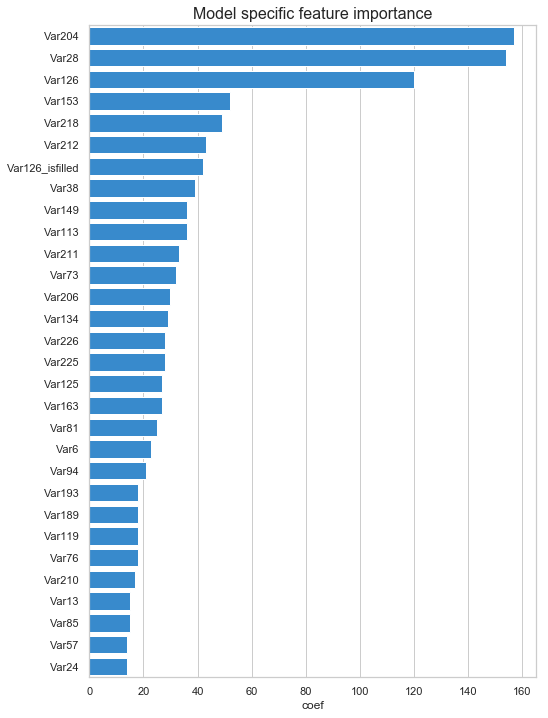

In [47]:
# Important features potrzebne jest do fitowania modeli w GridSearchCV
important_features = model_specific_feature_importance(X_train.columns, lgb_model.feature_importances_)

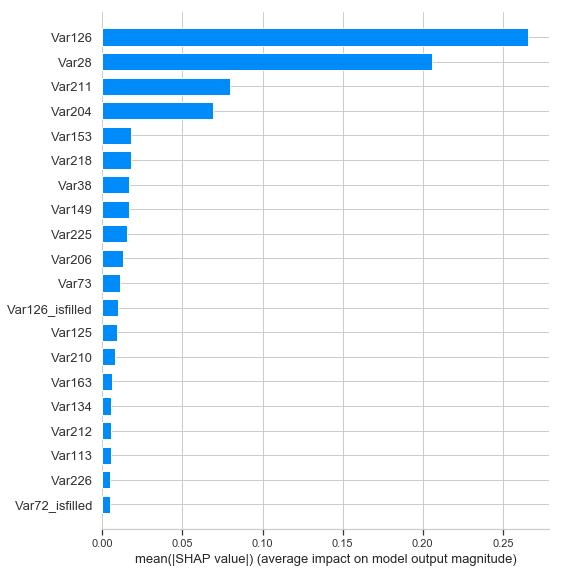

In [48]:
shap_feature_importance(lgb_model, X_train)

## Zapisanie najlepszego wyniku

In [ ]:
np.savetxt("WOJCEL.txt", y_pred_lgb_proba, fmt='%.18f',)